In [22]:
import numpy as np
import pandas as pd
from collections import namedtuple, defaultdict
import os
import pickle
import sys
import csv 
import cv2
import matplotlib.pyplot as plt
from math import sqrt

In [23]:
def getErrors(dots, grountruth):
    errors = []
    for i, sealion in enumerate(sealion_types):
        gt = grountruth[sealion].get_values()[0]
        detected = len(dots[i])
        errors.append(detected - gt)
    return errors

In [24]:
def merge(dotsA, dotsB, errorsA, errorsB):
    mergedDots = []
    mergedErrors = []
    for i, sealion in enumerate(sealion_types): 
        if np.abs(errorsA[i]) <= np.abs(errorsB[i]):
            mergedDots.append(dotsA[i])
            mergedErrors.append(errorsA[i])
        else:
            mergedDots.append(dotsB[i])
            mergedErrors.append(errorsB[i])
    return mergedDots, mergedErrors

In [25]:
def compare(dotsA, dotsB):
    differences = []
    unmatchedA = []
    unmatchedB = []
    for i, _ in enumerate(sealion_types):
        d, uA, uB = compareCoords(dotsA[i], dotsB[i])
        differences.append(d)
        unmatchedA.append(uA)
        unmatchedB.append(uB)        
    return differences, unmatchedA, unmatchedB

In [26]:
def compareCoords(coordsA, coordsB):
    threshold = 3*3+3*3
    distances = np.zeros((len(coordsA), len(coordsB)))

    for a, cA in enumerate(coordsA):
        for b, cB in enumerate(coordsB):
            dx = cA[0] - cB[0]
            dy = cA[1] - cB[1]
            distances[a,b] = dx*dx + dy*dy
    
    mi = min(len(coordsA), len(coordsB))
    ma = max(len(coordsA), len(coordsB))
    umatchedA = set(range(len(coordsA)))
    umatchedB = set(range(len(coordsB)))
    mapping = dict()

    for i in range(mi):
        best = np.argmin(distances.ravel())
        best_row = best // len(coordsB)
        best_col = best % len(coordsB)
        if distances[best_row, best_col] < threshold:
            mapping[best_col] = best_row
            distances[best_row, :] = 1e12
            distances[:, best_col] = 1e12
            umatchedA.remove(best_row)
            umatchedB.remove(best_col)
        else:
            break
    
    matched = len(mapping)
    unmatched = ma - matched
    return unmatched, [coordsA[i] for i in umatchedA], [coordsB[i] for i in umatchedB]

In [27]:
df = pd.read_csv("../data/sealion/correct_coordinates.csv")

In [28]:
sealion_types = ["adult_males", 
    "subadult_males",
    "adult_females",
    "juveniles",
    "pups"]

In [29]:
sealion_index = dict()
for i, s in enumerate(sealion_types):
    sealion_index[s] = i

In [80]:
dotsC = dict()

In [30]:
def populate_dots(r):
    filename = r["filename"]
    train_id, _ = os.path.splitext(filename)
    train_id = int(train_id)
    x, y = r["x_coord"], r["y_coord"]
    x, y = int(round(x)), int(round(y))
    index = sealion_index[r["category"]]
    
    if train_id not in dotsC:
        dotsC[train_id] = [[], [], [], [], []]
    dotsC[train_id][index].append((x, y))

In [82]:
df.head()

,Unnamed: 0,filename,y_coord,x_coord,category
0,0,0.jpg,31.0,4238.0,pups
1,1,0.jpg,41.0,4240.0,adult_females
2,2,0.jpg,59.0,4722.0,juveniles
3,3,0.jpg,74.0,3833.0,adult_females
4,4,0.jpg,80.0,2756.0,pups


In [83]:
_ = df.apply(populate_dots, axis=1)

In [84]:
for train_id, dots in dotsC.items():
    with open("../data/sealion/TrainDotsB/{}C.pkl".format(train_id), "wb") as pfile:
        pickle.dump(dots, pfile, pickle.HIGHEST_PROTOCOL)

In [31]:
def get_train_id(filename):
    directory, basename = os.path.split(filename)
    train_id, ext = os.path.splitext(basename)
    return int(train_id)

In [32]:
c_is_good = set([58, 66, 87, 110, 122, 148, 187, 235, 259, 270, 275, 277, 292, 310, 323, 328, 330, 338, 359, 368, 383, 395, 403, 431, 437, 462, 526, 529, 538, 578, 584, 604, 645, 658, 671, 684, 704, 741, 742, 744, 759, 773, 804, 822, 827, 845, 881, 886, 889, 912, 914, 920, 924, 939, 941])
def reprocess_all(train_ids=None):
    train_dir = "/home/lowik/sealion/data/sealion/Train/"
    dotted_dir = "/home/lowik/sealion/data/sealion/TrainDotted/"
    mask_dir = "/home/lowik/sealion/data/sealion/TrainMask/"
    debug_dir = "/home/lowik/sealion/data/sealion/TrainDebug/"
    dots_dir = "/home/lowik/sealion/data/sealion/TrainDotsB/"
    os.makedirs(debug_dir, exist_ok=True)
    os.makedirs(dots_dir, exist_ok=True)
    df = pd.read_csv(os.path.join(train_dir, "train.csv"))
    train_id_with_errors = []
    train_id_no_diff = []
    train_id_with_diff = []
    train_id_ok = []
    total_errors = dict()
    files_to_process = [filename for filename in os.listdir(train_dir) if filename.endswith("jpg")]
    for filename in files_to_process:
        train_id = get_train_id(filename)
        if train_ids is None or train_id in train_ids:
            #im_bgr = cv2.imread(os.path.join(train_dir, filename))
            im_dotted_bgr = cv2.imread(os.path.join(dotted_dir, filename))
            #im_mask = cv2.imread(os.path.join(mask_dir, filename), cv2.IMREAD_GRAYSCALE)
            
            
            with open(os.path.join(dots_dir, str(train_id) + ".pkl"), "rb") as ofile:
                    dotsA = pickle.load(ofile)
                
            if os.path.exists(os.path.join(dots_dir, str(train_id) + "C.pkl")):
                with open(os.path.join(dots_dir, str(train_id) + "C.pkl"), "rb") as ofile:
                    dotsB = pickle.load(ofile)
            else:
                dotsB = [[],[],[],[],[]]
            
            grountruth = df[df.train_id==int(train_id)]
            errorsA = getErrors(dotsA, grountruth)
            errorsB = getErrors(dotsB, grountruth)
            
            difference, _, _ = compare(dotsA, dotsB)
            if np.sum(np.abs(difference)) == 0:
                print("[{i}] - No Difference A vs B".format(i=train_id))
                train_id_no_diff.append(train_id)
            else:
                print("[{i}] - Difference A vs B: {d}".format(i=train_id, d=difference))
                train_id_with_diff.append(train_id)
            
            mergeDots, mergeErrors = merge(dotsA, dotsB, errorsA, errorsB)
            sumErrors = np.sum(np.abs(mergeErrors))
            
            if train_id in c_is_good:
                mergeDots = dotsB

            im_draw = draw_detected(im_dotted_bgr, mergeDots)
            cv2.imwrite(os.path.join(debug_dir, str(train_id) + "_merged.jpg"), im_draw)
            total_errors[train_id] = sumErrors
            if sumErrors > 0:
                train_id_with_errors.append(train_id)
                print("[{i}] - Total errors: {total} - {err}".format(i=train_id, total=sumErrors, err=mergeErrors))
            else:
                train_id_ok.append(train_id)
                print("[{i}] - ok".format(i=train_id))

            # Save dots
            with open(os.path.join(dots_dir, str(train_id) + "_merged.pkl"), "wb") as ofile:
                pickle.dump(mergeDots, ofile, pickle.HIGHEST_PROTOCOL)
    return train_id_with_errors, train_id_ok, train_id_no_diff, train_id_with_diff, total_errors

In [33]:
def draw_detected(im, dots):
    im_draw = im.copy()
    n = 5
    colors_rgb = [(1, 7, 244), (243, 17, 242), (5, 41, 79), (177, 54, 26), (26, 171, 43)]
    for i, centroids in enumerate(dots):
        for c in centroids:
            center = (int(round(c[0])), int(round(c[1])))
            cv2.circle(im_draw, center, 9, colors_rgb[i], 2)
    return im_draw

In [96]:
train_id_with_errors, train_id_ok, train_id_no_diff, train_id_with_diff, total_errors = reprocess_all()

[866] - No Difference A vs B
[866] - ok
[867] - No Difference A vs B
[867] - ok
[868] - No Difference A vs B
[868] - ok
[869] - Difference A vs B: [2, 3, 0, 0, 0]
[869] - ok
[87] - Difference A vs B: [0, 0, 1, 0, 0]
[87] - ok
[870] - No Difference A vs B
[870] - ok
[871] - No Difference A vs B
[871] - Total errors: 7 - [0, 0, -3, 0, -4]
[872] - No Difference A vs B
[872] - ok
[873] - No Difference A vs B
[873] - Total errors: 1 - [0, 0, 0, -1, 0]
[874] - No Difference A vs B
[874] - ok
[875] - No Difference A vs B
[875] - ok
[876] - No Difference A vs B
[876] - ok
[877] - No Difference A vs B
[877] - ok
[878] - No Difference A vs B
[878] - Total errors: 1 - [0, -1, 0, 0, 0]
[879] - No Difference A vs B
[879] - ok
[88] - No Difference A vs B
[88] - ok
[880] - No Difference A vs B
[880] - ok
[881] - Difference A vs B: [1, 0, 4, 0, 0]
[881] - Total errors: 1 - [0, 0, 0, -1, 0]
[882] - Difference A vs B: [2, 4, 5, 16, 0]
[882] - Total errors: 1 - [0, 0, -1, 0, 0]
[883] - No Difference A vs

[81] - Total errors: 19 - [-1, -3, -15, 0, 0]
[810] - No Difference A vs B
[810] - ok
[811] - No Difference A vs B
[811] - Total errors: 24 - [-7, -5, -12, 0, 0]
[812] - No Difference A vs B
[812] - ok
[813] - No Difference A vs B
[813] - Total errors: 1 - [0, 0, 0, -1, 0]
[814] - No Difference A vs B
[814] - Total errors: 1 - [0, 0, 0, -1, 0]
[815] - No Difference A vs B
[815] - ok
[816] - No Difference A vs B
[816] - ok
[817] - No Difference A vs B
[817] - ok
[818] - No Difference A vs B
[818] - ok
[819] - No Difference A vs B
[819] - ok
[82] - No Difference A vs B
[82] - ok
[820] - No Difference A vs B
[820] - ok
[821] - No Difference A vs B
[821] - ok
[822] - Difference A vs B: [0, 0, 1, 0, 0]
[822] - Total errors: 1 - [0, 0, 0, -1, 0]
[823] - No Difference A vs B
[823] - Total errors: 3 - [0, -3, 0, 0, 0]
[824] - No Difference A vs B
[824] - ok
[825] - No Difference A vs B
[825] - ok
[826] - No Difference A vs B
[826] - ok
[827] - Difference A vs B: [4, 0, 0, 0, 0]
[827] - Total e

[743] - ok
[744] - Difference A vs B: [0, 0, 0, 1, 0]
[744] - Total errors: 1 - [0, 0, 0, -1, 0]
[745] - No Difference A vs B
[745] - Total errors: 1 - [0, 0, -1, 0, 0]
[746] - No Difference A vs B
[746] - ok
[747] - No Difference A vs B
[747] - ok
[748] - No Difference A vs B
[748] - Total errors: 1 - [0, -1, 0, 0, 0]
[749] - No Difference A vs B
[749] - ok
[75] - No Difference A vs B
[75] - ok
[750] - No Difference A vs B
[750] - Total errors: 4 - [-2, 0, 0, -2, 0]
[751] - No Difference A vs B
[751] - Total errors: 5 - [0, -3, 0, -2, 0]
[752] - No Difference A vs B
[752] - ok
[753] - No Difference A vs B
[753] - ok
[754] - No Difference A vs B
[754] - Total errors: 2 - [0, 0, 0, -2, 0]
[755] - No Difference A vs B
[755] - ok
[536] - No Difference A vs B
[536] - ok
[537] - No Difference A vs B
[537] - ok
[538] - Difference A vs B: [1, 0, 2, 0, 0]
[538] - Total errors: 1 - [0, -1, 0, 0, 0]
[539] - No Difference A vs B
[539] - Total errors: 1 - [-1, 0, 0, 0, 0]
[54] - No Difference A vs

[454] - ok
[455] - No Difference A vs B
[455] - ok
[456] - No Difference A vs B
[456] - ok
[457] - No Difference A vs B
[457] - ok
[458] - No Difference A vs B
[458] - ok
[459] - No Difference A vs B
[459] - ok
[46] - No Difference A vs B
[46] - ok
[460] - No Difference A vs B
[460] - Total errors: 1 - [0, 0, 0, -1, 0]
[461] - No Difference A vs B
[461] - ok
[462] - Difference A vs B: [0, 0, 1, 0, 0]
[462] - Total errors: 2 - [-1, 0, 0, 0, -1]
[463] - No Difference A vs B
[463] - ok
[464] - No Difference A vs B
[464] - ok
[465] - No Difference A vs B
[465] - Total errors: 1 - [0, 0, 0, -1, 0]
[466] - No Difference A vs B
[466] - ok
[467] - No Difference A vs B
[467] - Total errors: 2 - [0, 0, 0, -2, 0]
[468] - No Difference A vs B
[468] - ok
[469] - Difference A vs B: [0, 2, 8, 7, 0]
[469] - ok
[47] - No Difference A vs B
[47] - Total errors: 2 - [0, -2, 0, 0, 0]
[470] - No Difference A vs B
[470] - ok
[471] - No Difference A vs B
[471] - ok
[472] - No Difference A vs B
[472] - ok
[473

[382] - ok
[383] - Difference A vs B: [0, 0, 0, 1, 0]
[383] - Total errors: 2 - [0, -2, 0, 0, 0]
[384] - No Difference A vs B
[384] - Total errors: 92 - [-7, -5, -61, -19, 0]
[385] - No Difference A vs B
[385] - ok
[386] - No Difference A vs B
[386] - Total errors: 2 - [0, -2, 0, 0, 0]
[387] - No Difference A vs B
[387] - ok
[388] - No Difference A vs B
[388] - Total errors: 1 - [-1, 0, 0, 0, 0]
[389] - No Difference A vs B
[389] - ok
[39] - No Difference A vs B
[39] - ok
[390] - No Difference A vs B
[390] - ok
[391] - No Difference A vs B
[391] - ok
[392] - No Difference A vs B
[392] - ok
[393] - No Difference A vs B
[393] - ok
[394] - No Difference A vs B
[394] - Total errors: 4 - [0, -4, 0, 0, 0]
[395] - Difference A vs B: [0, 0, 2, 0, 0]
[395] - Total errors: 2 - [0, -1, 0, -1, 0]
[396] - No Difference A vs B
[396] - ok
[397] - No Difference A vs B
[397] - ok
[398] - No Difference A vs B
[398] - Total errors: 3 - [0, -3, 0, 0, 0]
[399] - No Difference A vs B
[399] - ok
[4] - No Dif

[31] - No Difference A vs B
[31] - ok
[310] - Difference A vs B: [0, 0, 0, 1, 0]
[310] - ok
[311] - Difference A vs B: [2, 1, 14, 9, 3]
[311] - ok
[312] - No Difference A vs B
[312] - Total errors: 1 - [0, 0, -1, 0, 0]
[313] - No Difference A vs B
[313] - ok
[314] - No Difference A vs B
[314] - ok
[315] - No Difference A vs B
[315] - ok
[0] - No Difference A vs B
[0] - ok
[1] - No Difference A vs B
[1] - ok
[10] - No Difference A vs B
[10] - ok
[100] - No Difference A vs B
[100] - ok
[101] - No Difference A vs B
[101] - ok
[102] - No Difference A vs B
[102] - ok
[103] - No Difference A vs B
[103] - ok
[104] - No Difference A vs B
[104] - ok
[105] - No Difference A vs B
[105] - Total errors: 5 - [0, 0, -1, -4, 0]
[106] - No Difference A vs B
[106] - ok
[107] - No Difference A vs B
[107] - ok
[108] - No Difference A vs B
[108] - Total errors: 1 - [-1, 0, 0, 0, 0]
[109] - No Difference A vs B
[109] - ok
[11] - No Difference A vs B
[11] - Total errors: 2 - [0, -2, 0, 0, 0]
[110] - Differen

In [141]:
df_c = pd.read_csv("../data/sealion/correct_coordinates.csv")

In [162]:
diff_with_C = []
for train_id in train_id_with_diff:
    if os.path.exists("/home/lowik/sealion/data/sealion/TrainDotsB/{}C.pkl".format(train_id)):
        diff_with_C.append(train_id)

In [163]:
len(diff_with_C)

79

In [113]:
c_is_good = set([58, 66, 87, 110, 122, 148, 187, 235, 259, 270, 275, 277, 292, 310, 323, 328, 330, 338, 359, 368, 383, 395, 403, 431, 437, 462, 526, 529, 538, 578, 584, 604, 645, 658, 671, 684, 704, 741, 742, 744, 759, 773, 804, 822, 827, 845, 881, 886, 889, 912, 914, 920, 924, 939, 941])

In [34]:
df = pd.read_csv(os.path.join("/home/lowik/sealion/data/sealion/Train/", "train.csv"))
def check(train_id):
    im = cv2.imread("../data/sealion/TrainDotted/{}.jpg".format(train_id))
    with open("../data/sealion/TrainDotsB/{}.pkl".format(train_id), "rb") as pfile:
        dots = pickle.load(pfile)
    with open("../data/sealion/TrainDotsB/{}C.pkl".format(train_id), "rb") as pfile:
        dotsC = pickle.load(pfile)
    im_draw = draw_detected(im.copy(), dots)
    im_drawC = draw_detected(im.copy(), dotsC)
    cv2.imwrite("../data/check.jpg", im_draw)
    cv2.imwrite("../data/checkC.jpg", im_drawC)
    _, uA, uB = compare(dots, dotsC)
    s = 0
    plt.figure(figsize=(5, 5 * (len(uA) + len(uB))))
    for us in uA:
        for (x, y) in us:
            s += 1
            im = im_draw[y - 64: y+64, x-64:x+64, :]
            print("A: {x}, {y}".format(x=x, y=y))
            plt.subplot(len(uA) + len(uB), 1, s)
            plt.imshow(im)
            plt.title("A: {x}, {y}".format(x=x, y=y))
    for us in uB:
        for (x, y) in us:
            s += 1
            im = im_drawC[y - 64:y+64, x-64:x+64, :]
            print("C: {x}, {y}".format(x=x, y=y))
            plt.subplot(len(uA) + len(uB), 1, s)
            plt.imshow(im)
            plt.title("C: {x}, {y}".format(x=x, y=y))
        
    print(" ".join([str(len(d)) for d in dots]))    
    print(" ".join([str(len(d)) for d in dotsC]))    
    print(df[df.train_id == train_id])

In [35]:
%matplotlib inline

A: 1622, 1032
A: 1715, 1151
A: 1510, 1229
10 6 139 150 0
10 6 136 150 0
     train_id  adult_males  subadult_males  adult_females  juveniles  pups
418       418           11               6            139        150     0


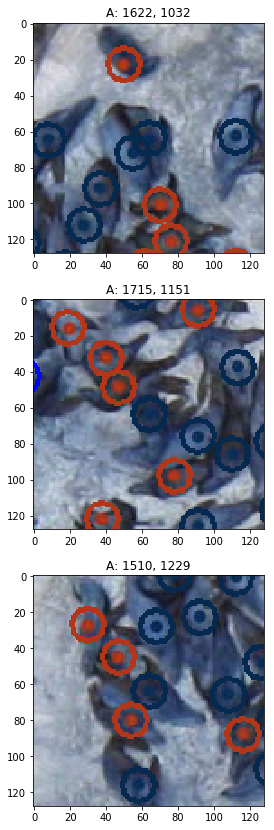

In [41]:
check(418)

Correct 80

In [6]:
with open("../data/sealion/TrainDotsB/80C.pkl", "rb") as pfile:
    dotsC_80 = pickle.load(pfile)

dotsC_80[1].append((1697, 414))

dotsC_80[2].remove(((1697, 414)))

with open("../data/sealion/TrainDotsB/80Corrected.pkl", "wb") as pfile:
    pickle.dump(dotsC_80, pfile, protocol=pickle.HIGHEST_PROTOCOL)

Correct 170

In [12]:
with open("../data/sealion/TrainDotsB/170C.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

dots[0].remove((3234, 623))

dots[2].append((3234, 623))

with open("../data/sealion/TrainDotsB/170Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)



Correct 174

In [27]:
with open("../data/sealion/TrainDotsB/174C.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

dots[0].remove((3710, 3500))

with open("../data/sealion/TrainDotsB/174Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)

Correct 177

In [31]:
with open("../data/sealion/TrainDotsB/177C.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

dots[1].remove((5186, 2630))

dots[1].append((5185, 2616))

with open("../data/sealion/TrainDotsB/177Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)

Correct 186

In [84]:
with open("../data/sealion/TrainDotsB/186.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

dots[2].append((3095, 1574))

with open("../data/sealion/TrainDotsB/186Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)

Correct 197

In [43]:
with open("../data/sealion/TrainDotsB/197.pkl", "rb") as pfile:
    dots = pickle.load(pfile)


dots[2].append((2676, 2028))

with open("../data/sealion/TrainDotsB/197Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)



Correct 240

In [50]:
with open("../data/sealion/TrainDotsB/240C.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

dots[4].remove((3178, 3676))

with open("../data/sealion/TrainDotsB/240Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)

Correct 291

In [59]:
with open("../data/sealion/TrainDotsB/291.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

dots[0].remove((1456, 48))
dots[0].remove((1479, 48))

with open("../data/sealion/TrainDotsB/291Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)

Correct 416

In [68]:
with open("../data/sealion/TrainDotsB/416C.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

dots[3].append((1385, 543))

with open("../data/sealion/TrainDotsB/416Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)

Correct 418

In [69]:
with open("../data/sealion/TrainDotsB/418.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

dots[2].append((1648, 1109))

with open("../data/sealion/TrainDotsB/418Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)



Correct 452

In [73]:
with open("../data/sealion/TrainDotsB/452C.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

dots[4].append((4379, 2287))

with open("../data/sealion/TrainDotsB/452Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)

Correct 803

In [77]:
with open("../data/sealion/TrainDotsB/803.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

dots[2].append((1356, 3349))

with open("../data/sealion/TrainDotsB/803Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)

Correct 828

In [80]:
with open("../data/sealion/TrainDotsB/828C.pkl", "rb") as pfile:
    dots = pickle.load(pfile)

dots[2].append((2682, 2349))

with open("../data/sealion/TrainDotsB/828Corrected.pkl", "wb") as pfile:
       pickle.dump(dots, pfile, protocol=pickle.HIGHEST_PROTOCOL)



In [1]:
import os

In [2]:
root_dir = "/home/lowik/sealion/data/sealion/"

In [3]:
filenames = [f for f in os.listdir(os.path.join(root_dir, "Train")) if f.endswith("jpg")]

In [4]:
import shutil

In [6]:
dst_dir = os.path.join(root_dir, "TrainDots")
os.makedirs(dst_dir, exist_ok=True)

In [8]:
for fn in filenames:
    train_id, _ = os.path.splitext(fn)
    train_id = int(train_id)
    if os.path.exists(os.path.join(root_dir, "TrainDotsB", "{}Corrected.pkl".format(train_id))):
        shutil.copy(os.path.join(root_dir, "TrainDotsB", "{}Corrected.pkl".format(train_id)),
                   os.path.join(dst_dir, "{}.pkl".format(train_id)))
        print("Use corrected ", train_id)
    else:
        shutil.copy(os.path.join(root_dir, "TrainDotsB", "{}_merged.pkl".format(train_id)),
                   os.path.join(dst_dir, "{}.pkl".format(train_id)))

Use corrected  80
Use corrected  803
Use corrected  828
Use corrected  452
Use corrected  416
Use corrected  418
Use corrected  240
Use corrected  291
Use corrected  170
Use corrected  174
Use corrected  177
Use corrected  186
Use corrected  197


In [136]:
def create_coords_df(dots_dir):
    data = []
    n_total = 0
    for fn in sorted(os.listdir(dots_dir)):
        train_id, _ = os.path.splitext(fn)
        train_id = int(train_id)
        with open(os.path.join(dots_dir, fn), "rb") as pfile:
            dots = pickle.load(pfile)
            for i, ds in enumerate(dots):
                for x, y in ds:
                    data.append({"train_id": train_id, "y_coord": y, "x_coord": x, "category": sealion_types[i], "id": i})
                    n_total += 1
    df = pd.DataFrame(data, index=range(len(data)), columns=["train_id", "x_coord", "y_coord", "category", "id"])
    df = df.sort_values(by=["train_id", "y_coord", "x_coord", "id"])
    df = df.reset_index()
    df = df[["train_id", "y_coord", "x_coord", "category"]]
    
    return df

In [137]:
df = create_coords_df("/home/lowik/sealion/data/sealion/TrainDots/")

In [133]:
df.to_csv("../data/sealion/my_correct_coordinates.csv")

In [138]:
def create_counts_df(dots_dir):
    data = []
    n_total = 0
    for fn in sorted(os.listdir(dots_dir)):
        train_id, _ = os.path.splitext(fn)
        train_id = int(train_id)
        with open(os.path.join(dots_dir, fn), "rb") as pfile:
            dots = pickle.load(pfile)
            row = {"train_id": train_id}
            for i, ds in enumerate(dots):
                row[sealion_types[i]] = len(ds)                
            data.append(row)

    df = pd.DataFrame(data, index=range(len(data)), columns=["train_id","adult_males","subadult_males","adult_females","juveniles","pups"])
    df = df.sort_values(by=["train_id"])
    df = df.reset_index()
    df = df[["train_id","adult_males","subadult_males","adult_females","juveniles","pups"]]
    
    return df

In [139]:
df = create_counts_df("/home/lowik/sealion/data/sealion/TrainDots/")

In [141]:
df.to_csv("../data/sealion/my_correct_counts.csv", index=False)

In [128]:
!head "../data/sealion/Train/train.csv"

train_id,adult_males,subadult_males,adult_females,juveniles,pups
0,62,12,486,42,344
1,2,20,0,12,0
2,2,0,38,20,0
3,8,5,41,7,38
4,6,9,2,0,0
5,6,4,14,4,19
6,2,5,20,18,0
7,6,2,33,16,3
8,9,5,76,4,51


In [142]:
!head ../data/sealion/my_correct_counts.csv

train_id,adult_males,subadult_males,adult_females,juveniles,pups
0,62,12,486,42,344
1,2,20,0,12,0
2,2,0,37,19,0
3,4,0,5,2,3
4,6,9,2,0,0
5,6,4,14,4,19
6,2,5,20,18,0
7,0,0,0,0,0
8,9,5,76,4,51


In [143]:
!head ../data/sealion/MismatchedTrainImages.txt

train_id
3
7
9
21
30
34
71
81
89


In [216]:
missMatched = set()
with open("../data/sealion/MismatchedTrainImages.txt", "r") as f:
    f.readline()
    for line in f:
        missMatched.add(int(line))

In [217]:
len(missMatched)

57

840: missing one sub_adult

71: some wrong dots

In [213]:
im = cv2.imread("../data/sealion/Train/857.jpg")
mask = cv2.imread("../data/sealion/TrainMask/857.png", cv2.IMREAD_GRAYSCALE)
im = cv2.bitwise_and(im, im, mask=mask)
with open("../data/sealion/TrainDots/857.pkl", "rb") as p:
    dots = pickle.load(p)

imd = draw_detected(im, dots)

cv2.imwrite("../data/c.png", imd)

True

In [218]:
corrects = set([30, 380, 469, 475, 530, 531, 605, 614, 621, 638, 644, 781, 794, 840, 882, 913, 946])

In [222]:
real_missMatched = missMatched.difference(corrects)

In [224]:
real_missMatched.add(857)

In [225]:
len(real_missMatched)

41

In [226]:
with open("../data/sealion/real_missmatched", "w") as f:
    f.write("train_id\n")
    for i in real_missMatched:
        f.write(str(i) + "\n")

In [198]:
df = create_coords_df("/home/lowik/sealion/data/sealion/TrainDots/")
df = df[~df.train_id.isin(real_missMatched)]
df = df.reset_index()
df =  df[["train_id", "y_coord", "x_coord", "category"]]

In [199]:
df.to_csv("../data/sealion/my_correct_coordinates_no_missmatched.csv")

In [200]:
df = create_counts_df("/home/lowik/sealion/data/sealion/TrainDots/")
df = df[~df.train_id.isin(real_missMatched)]

In [202]:
df.to_csv("../data/sealion/my_correct_counts_no_missmatched.csv", index=False)

In [203]:
dfc = pd.read_csv("../data/sealion/correct_coordinates.csv")

In [204]:
my_tids = set(df.train_id)

In [210]:
tids_c = set(dfc.filename)
tids_c = set([int(t[:-4]) for t in tids_c])

857 should be removed

In [211]:
my_tids.difference(tids_c)

{30,
 380,
 469,
 475,
 530,
 531,
 605,
 614,
 621,
 638,
 644,
 781,
 794,
 840,
 857,
 882,
 913,
 946}

In [212]:
sorted(corrects)

[30,
 380,
 469,
 475,
 530,
 531,
 605,
 614,
 621,
 638,
 644,
 781,
 794,
 840,
 882,
 913,
 946]